# Projet Navire a la mano - Yanis Farhat et Benjamin Clene

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os

# Test data

We load the test data and prepare it by resizing it with the bicubic method and we normalize it.  
We decided to have a 32x48 image size so we would have more informations.

In [2]:
X_test = np.load('/kaggle/input/ships16x24/test.npy/test.npy', allow_pickle=True)
print(X_test.shape)
img_size = (2*16,2*24)

(3698, 16, 24, 3)


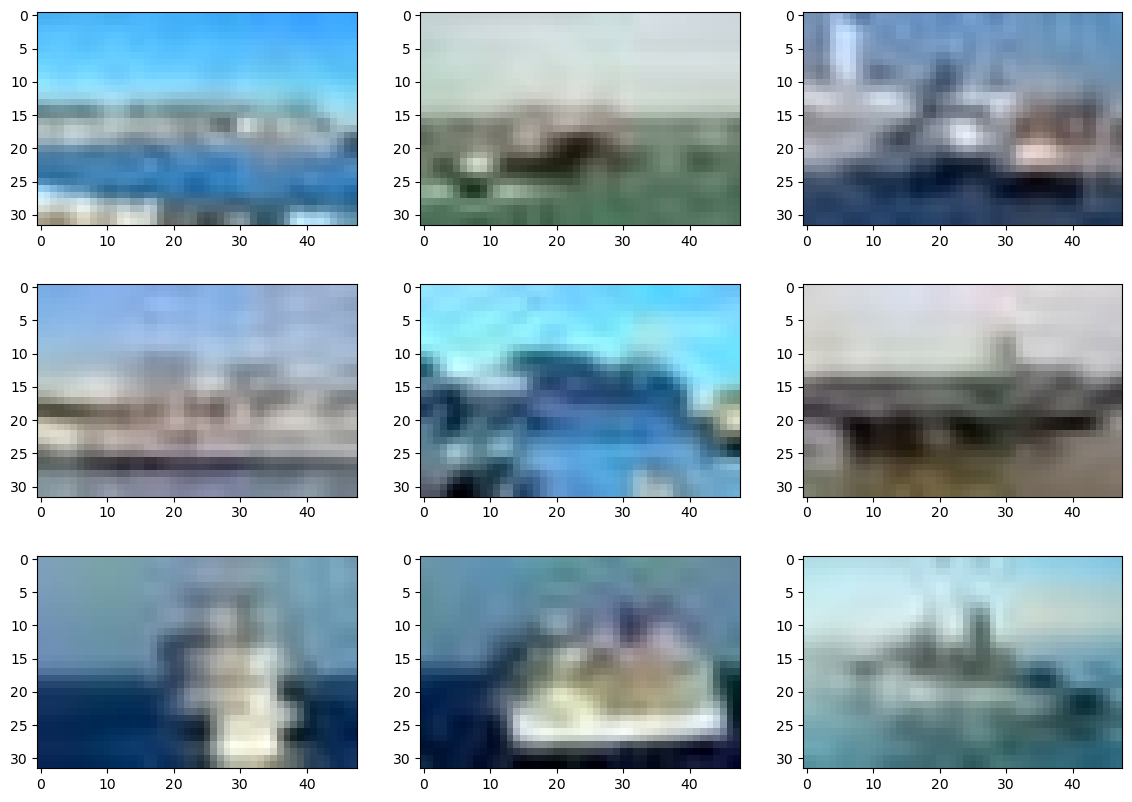

In [3]:
from PIL import Image

images = X_test.copy()
resized_test = np.zeros((3698, img_size[0], img_size[1], 3))

for i in range(images.shape[0]):
    img = Image.fromarray(images[i].astype('uint8'))
    img = img.resize((img_size[1], img_size[0]), Image.BICUBIC)
    resized_test[i] = np.array(img).astype('float32') / 255

plt.figure(figsize=(14,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(resized_test[i])
plt.show()

# Train Data

We use flow_from_directory so we have less RAM usage.  
And we also used a custom ImageDataGenerator to be sure that the resizing method (i.e BICUBIC) was the same that the one used for the test data. We also use horizontal_flip^as a data augmentation, it gave us better results.

In [4]:
import tensorflow as tf

SEED = 100
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 32
np.random.seed(SEED)
tf.random.set_seed(SEED)

directory = "/kaggle/input/ships16x24/ships16x24/ships_16x24_10cat/data"
our_class_name = [os.path.basename(dirname) for dirname, _, filenames in os.walk(directory)][1:]
print(our_class_name)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

['methanier_scaled', 'corvette_scaled', 'containership_scaled', 'cruiser_scaled', 'cv_scaled', 'coastguard_scaled', 'destroyer_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

class CustomImageDataGenerator2(ImageDataGenerator):
    def apply_transform(self, x, transform_parameters):
        '''x = Image.fromarray(x.astype('uint8'))
        if 'resize' in transform_parameters:
            x = x.resize(transform_parameters['resize'], Image.BICUBIC)
        x = np.array(x).astype('float32')'''
        x = tf.image.rgb_to_grayscale(x)
        x = np.copy(x)
        return super().apply_transform(x, transform_parameters)

class CustomImageDataGenerator(ImageDataGenerator):
    def apply_transform(self, x, transform_parameters):
        x = Image.fromarray(x.astype('uint8'))
        if 'resize' in transform_parameters:
            x = x.resize(transform_parameters['resize'], Image.BICUBIC)
        x = np.array(x).astype('float32')
        return super().apply_transform(x, transform_parameters)

train_datagen = CustomImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    directory,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle = True,
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    directory,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle = True,
    subset='validation')

Found 28417 images belonging to 10 classes.
Found 7098 images belonging to 10 classes.


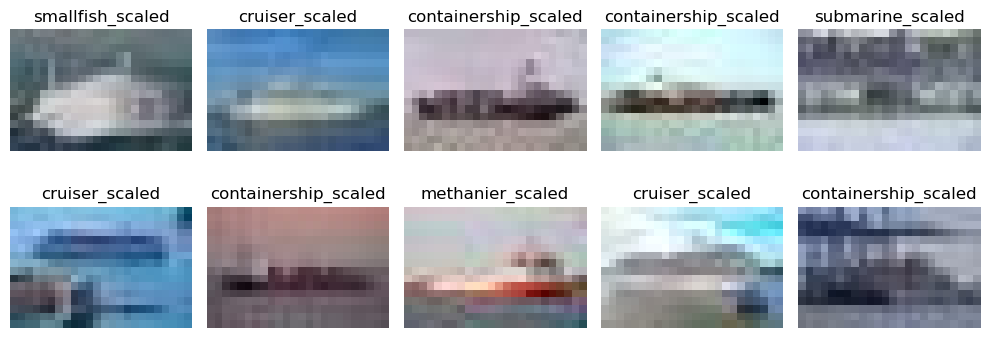

In [6]:
x, y = train_generator.next()
class_indices = train_generator.class_indices
labels = dict((v,k) for k,v in class_indices.items())

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(x[i])
    axes[i].set_title(labels[np.argmax(y[i])])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Class imbalance

To counter the class imbalance we use the compute_class_weight from sklearn to create a dictionnary of class_weights.

In [7]:
from sklearn.utils import class_weight
nb_of_class_samples = []

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        nb_of_class_samples.append(dirname.split('/')[-1])

nb_samples = np.asarray(nb_of_class_samples)

class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(nb_samples), y=nb_samples)
class_weight_dict = dict(enumerate(class_weights))

print(class_weights)

[1.13903143 0.65117345 1.32419836 0.6598848  1.9438971  0.69541805
 1.11019068 1.18383333 1.36491161 1.12961196]


# The model

The model architecture is insipred by the VGG16 architecture, so we tried to adapt it to the 32x48 image size.  
We found that the droupout 0.25 in the convolution layers and droupout 0.5 in the dense layers allowed us to achieve the best balance between underfitting and overfitting.

In [8]:
### Create the model ###
from keras import layers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten
IMG_SIZE = 32

def first_model():
    print("first_model")
    model = Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    

    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    return model

model = first_model()
print("Nombre de couches : ", len(model.layers))
model.build(input_shape=(None, img_size[0], img_size[1], 1))
model.summary()

first_model
Nombre de couches :  24
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 24, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 24, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)  

In [9]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint

# Define the file path to save the best model
checkpoint_path = 'best_model'

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max',patience=4)

def scheduler(epoch, lr):
    if epoch < 10:
         return lr
    else:
        return lr * tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = first_model()
model.compile(loss='categorical_crossentropy',
          optimizer='adam',      
          metrics=['accuracy'])
model_history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=[LearningRateScheduler, checkpoint]
)

first_model
Epoch 1/40


2023-05-28 19:15:06.346117: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


889/889 [==============================] - ETA: 0s - loss: 2.3088 - accuracy: 0.3033
Epoch 1: val_accuracy improved from -inf to 0.32784, saving model to best_model
889/889 [==============================] - 143s 152ms/step - loss: 2.3088 - accuracy: 0.3033 - val_loss: 1.9177 - val_accuracy: 0.3278 - lr: 0.0010
Epoch 2/40
888/889 [============================>.] - ETA: 0s - loss: 1.6306 - accuracy: 0.4606
Epoch 2: val_accuracy improved from 0.32784 to 0.50211, saving model to best_model
889/889 [==============================] - 41s 46ms/step - loss: 1.6302 - accuracy: 0.4608 - val_loss: 1.5250 - val_accuracy: 0.5021 - lr: 0.0010
Epoch 3/40
889/889 [==============================] - ETA: 0s - loss: 1.4413 - accuracy: 0.5165
Epoch 3: val_accuracy did not improve from 0.50211
889/889 [==============================] - 37s 41ms/step - loss: 1.4413 - accuracy: 0.5165 - val_loss: 1.5232 - val_accuracy: 0.4925 - lr: 0.0010
Epoch 4/40
889/889 [==============================] - ETA: 0s - loss:

# Data analyze

We can clearly see that the model is stuck at 0.74 and it's just overfitting at the end, but we obtain 0.8 on the submission.  
we tried to add more dropout or convolutions but it couldn't solve the problem.

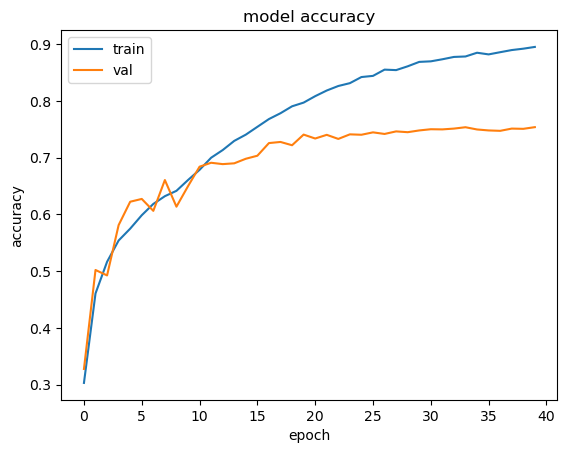

In [10]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
best_model = tf.keras.models.load_model(checkpoint_path)
res = best_model.predict(resized_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="Id")

116/116 [==============================] - 1s 3ms/step


In [12]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv